# Fit for first guesses on $\Gamma$ GP prior parameters

We will impose a Gaussian Process (GP) prior on the linewidth $\Gamma$ in our peakbag model. 

According to Appourchaux et al. 2014, we can describe the linewidth $\Gamma$ as:

$\ln(\Gamma) = (\alpha\ln(\nu/\nu_{\rm max}) + \ln\Gamma_\alpha) + \Large(\frac{\ln\Delta\Gamma_{\rm dip}}{1 + \Large(\frac{2\ln(\nu/\nu_{\rm dip})}{\ln(W_{\rm dip}/\nu_{\rm max}\Large)}\Large)}\Large)$

where we in principle have a power law tweaked by the location of a dip in the power law at $\nu_{\rm dip}$.

Instead of fitting this complex relation, we'll use a Gaussian Process and marginalise over all functions in existence, and apply this as the prior on the linewidth.

To approximate this relation we will use a squared exponential kernel:

$K_{i, j} = \alpha^2 \times \exp\left(\frac{-(\nu_i - \nu_j)^2}{2\rho^2}\right)$

where $\nu$ is the frequency and $K$ is the GP kernel, $\alpha$ is the spread and $\rho$ is the length scale. Note that I'm using the same language as the Stan User manual (some other implementations might call these $\sigma$ and $L$ respectively).

To use this effectively we will need rough first guesses for $\alpha$ and $\rho$. We will get this by reading in some mode linewidths from some random LEGACY stars and fitting a GP to them, marginalising over $\alpha$ and $\rho$.

We want:
- Some idea of the range of $\alpha$
- A rough relation for $\rho$ as a function of $\Delta\nu$ for main sequence stars

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
from astropy.io import ascii

## Read in LEGACY data

Looking at Appourchaux+14, Figure 3, we see that the shape of the $\Gamma(\nu)$ function depends on $T_\rm{eff}$. So we'll take 3 stars, one in the middle and one at each extreme of temperature on our sample.

In [2]:
#Read in stellar parameters
mal = pd.read_csv('../data/malatium.csv', index_col=0)
mal = mal[mal.source == 'L']

#Read in the mode IDS
pb = ascii.read('../data/legacy_modeids.txt').to_pandas()

In [3]:
mal.sort_values(by='Teff', inplace=True)
mal.reset_index(inplace=True, drop=True)
testteffs = [mal.Teff[0], mal.Teff[int(len(mal)/2)], mal.Teff.values[-1]]
testkics = [mal.KIC[0], mal.KIC[int(len(mal)/2)], mal.KIC.values[-1]]

## Lets construct the GP fitting process

In [7]:
code = '''
data {
    int N;
    real locs[N]; // The mode frequencies
    vector[N] lw; // The mode linewidths
    vector[N] mu; // The mean of the GP
    vector[N] v; // The variance on lw
}
parameters {
    real<lower=0> rho;
    real<lower=0> alpha;
}
model {
    matrix[N, N] GP =   cov_exp_quad(locs, alpha, rho)
                     + diag_matrix(v);
                     
    alpha ~ normal(0, 10);
    rho ~ normal(0, 10);
    lw ~ multi_normal(mu, GP);
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d8a055f1cd642adbf35bf6d8dae71ce7 NOW.
/Users/Oliver/Library/Python/3.6/lib/python/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/qv/cb2zc0gd48s1jndxjkxw8rqc0000gn/T/tmpd51tnnsa/stanfit4anon_model_d8a055f1cd642adbf35bf6d8dae71ce7_6712455460463403283.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


## Now lets fit each of the stars in turn

Instead of setting the mean $\mu$ of the GP to be equal to an empirical relation, we will just set it to be $1\, \mu Hz$. This is roughly the right range for MS stars.

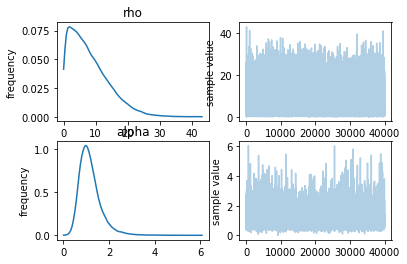

Inference for Stan model: anon_model_d8a055f1cd642adbf35bf6d8dae71ce7.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho     7.93    0.04   6.04    0.3   3.14   6.69  11.45  22.38  20580    1.0
alpha   1.17  4.0e-3   0.49   0.48   0.84   1.08   1.39   2.37  15149    1.0
lp__    -4.5    0.01    1.2  -7.71  -4.97  -4.14  -3.65  -3.33   9562    1.0

Samples were drawn using NUTS at Wed May 15 16:23:16 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


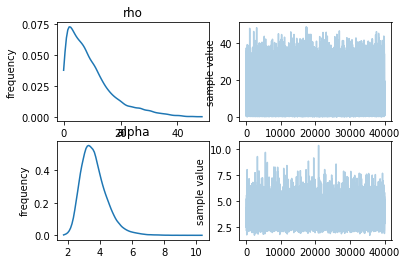

Inference for Stan model: anon_model_d8a055f1cd642adbf35bf6d8dae71ce7.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho     9.46    0.06   8.13   0.35   3.34   7.34  13.04  31.13  18664    1.0
alpha   3.65  6.6e-3   0.81   2.43   3.08   3.53   4.09   5.58  15032    1.0
lp__  -22.55    0.01   1.08 -25.46 -22.99 -22.25 -21.75 -21.42  11201    1.0

Samples were drawn using NUTS at Wed May 15 16:23:23 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


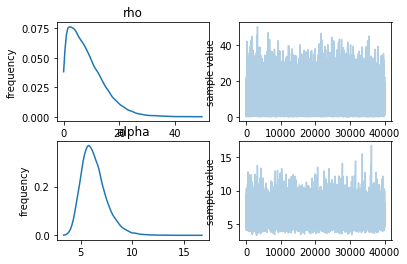

Inference for Stan model: anon_model_d8a055f1cd642adbf35bf6d8dae71ce7.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho     8.21    0.04   6.35   0.33   3.27   6.87  11.75  23.64  22287    1.0
alpha   6.29  9.7e-3   1.22   4.41   5.42   6.11   6.95   9.17  16016    1.0
lp__  -34.26    0.01   1.11 -37.21 -34.72 -33.93 -33.46 -33.16  10918    1.0

Samples were drawn using NUTS at Wed May 15 16:23:29 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [10]:
alphas = np.zeros(len(testkics))
rhos = np.zeros(len(testkics))
for idx, kic in enumerate(testkics):
    lw = pb[pb.KIC==str(kic)].dropna().Width.values
    v = pb[pb.KIC==str(kic)].dropna().e_Width.values
    f = pb[pb.KIC==str(kic)].dropna().Freq.values
    data = {'N':len(f),
             'locs':f,
           'lw':lw,
            'v':v,
           'mu' : np.zeros(len(f))}
    fit = sm.sampling(data=data, iter=20000, chains=4)
    fit.plot()
    plt.show()
    print(fit)
    alphas[idx] = np.median(fit['alpha'])
    rhos[idx] = np.median(fit['rho'])

## Lets plot the output
We want to see:
- Whether the GP matches the data nicely
- How $\rho$ scales with $\Delta\nu$
- How $\alpha$ scales with $T_\rm{eff}$

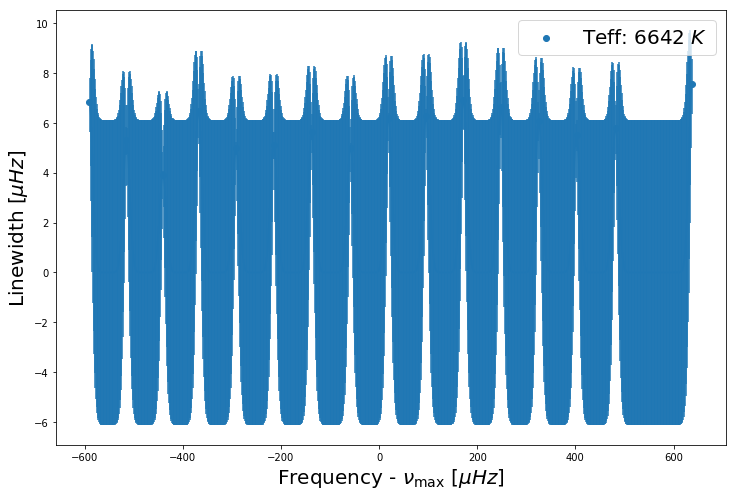

In [12]:
fig, ax = plt.subplots(figsize=(12,8))

def kernel(x, y, p):
    return p[0]**2 * np.exp(-0.5 * np.subtract.outer(x, y)**2 / p[1]**2)

def predict(t_2, t_1, kernel, p, y_1):
    B = kernel(t_1, t_2, p).T
    C = kernel(t_2, t_2, p)
    A = kernel(t_1, t_1, p)
    Ainv = np.linalg.inv(A)
    y_pred = np.dot(B, Ainv).dot(y_1)
    sigma_new = C - np.dot(B, Ainv).dot(B.T)
    return y_pred, np.diagonal(sigma_new)**0.5

# for idx, kic in enumerate(testkics[0]):
idx=2
kic = testkics[idx]

lw = pb[pb.KIC==str(kic)].dropna().Width.values
f = pb[pb.KIC==str(kic)].dropna().Freq.values
numax = mal[mal.KIC==kic].numax.values[0]

theta = [alphas[idx], rhos[idx]]

f2 = np.linspace(f.min(), f.max(), 1000)
lw_pred, sigmas = predict(f2, f, kernel, theta, lw)

ax.errorbar(f2 - numax, lw_pred, yerr=sigmas, capsize=0)
ax.scatter(f- numax, lw, label=r'Teff: {} $K$'.format(testteffs[idx]))

ax.set_ylabel(r'Linewidth [$\mu Hz$]', fontsize=20)
ax.set_xlabel(r'Frequency - $\nu_{\rm max}$ [$\mu Hz$]', fontsize=20)
ax.legend(fontsize=20)
# ax.set_yscale('log')